# Agent-based models (ABMs)

Agent-Based Models (ABMs), or "individual-based models", are used to simulate the behaviors and interactions of individuals, or "agents". In epidemiology, ABMs are particularly useful for understanding the dynamics of infectious disease transmission, as they can capture <span style="color:orange">heterogeneity</span> in individual behavior, such as mobility, susceptibility and other. Unlike compartmental models, which rely on aggregate populations, ABMs represent each individual as a discrete agent whose state evolves based on predefined rules and interactions with others. These models enable us to explore how micro-level processes, such as social contact patterns or intervention strategies, influence macro-level outcomes, such as epidemic spread or herd immunity. By incorporating randomness at individual level, ABMs provide a flexible and granular approach to studying complex epidemiological phenomena and testing public health interventions.

In [ ]:
import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import numpy as np

## SI-ABM: simulation

Let us construct a forward simulation with two possible states - susseptible (`S`) and infected (`I`). We assign `initial_infections` randomly following the Bernoulli distribution an initial probability of  being infected `initial_infected`.

In [34]:
def abm_SI(num_agents, num_steps, p_infect, initial_infected):
    states = jnp.zeros(num_agents)  
    initial_infections = jax.random.bernoulli(jax.random.PRNGKey(0), initial_infected, (num_agents,))
    states = states + initial_infections  # initialize some as infected

    S_list = []
    I_list = []

    for step in range(num_steps):
        S_list.append(jnp.sum(1 - states))  # count susceptible agents - we don't need these for inference, but for viz
        I_list.append(jnp.sum(states))      # count infected agents - we don't need these for inference, but for viz

        random_vals = jax.random.uniform(jax.random.PRNGKey(step), (num_agents,))
        new_infections = (random_vals < p_infect) * (1 - states)
        states = states + new_infections

    S_list.append(jnp.sum(1 - states))  # final count of susceptibles - don't need for inference, but for viz
    I_list.append(jnp.sum(states))      # final count of infected - don't need for inference, but for viz

    return jnp.clip(states, 0, 1), S_list, I_list


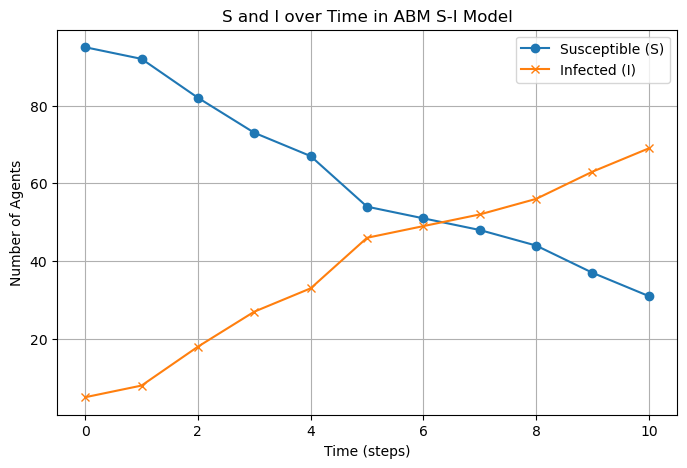

In [79]:
# synthetic data
num_agents = 100
num_steps = 10
true_p_infect = 0.1
true_initial_infected = 0.05

#run forward the ABM S-I model
final_states, S_counts, I_counts = abm_SI(num_agents, num_steps, true_p_infect, true_initial_infected)

# plot S and I over time
plt.figure(figsize=(8, 5))
plt.plot(range(num_steps + 1), S_counts, label="Susceptible (S)", marker='o')
plt.plot(range(num_steps + 1), I_counts, label="Infected (I)", marker='x')
plt.xlabel("Time (steps)")
plt.ylabel("Number of Agents")
plt.title("S and I over Time in ABM S-I Model")
plt.legend()
plt.grid(True)
plt.show()

`````{admonition} Group Task
Experiment with the following inputs in the above model:
- increase and disease the number of time steps `num_steps`. How does that change the result?
- increase and disease the infections probability `true_p_infect`. How does that change the result?
- increase and disease the number of agents `num_agents`. How does that affect the result?
`````

## SI-ABM: inference

There is a lot of flexibility that ABM simulations allow. But can we perform inference for them as easily as we did for ODE-based models? Yes! Thanks to automatic differentiation.

In [80]:
def numpyro_abm_SI(num_agents, num_steps, data=None):

    p_infect = numpyro.sample("p_infect", dist.Beta(2, 6))
    initial_infected = numpyro.sample("initial_infected", dist.Beta(2, 10))

    final_states, S_t, I_t = abm_SI(num_agents, num_steps, p_infect, initial_infected)

    if data is not None:
        numpyro.sample("obs", dist.Bernoulli(final_states), obs=data)

In [81]:
# inference
nuts_kernel = NUTS(numpyro_abm_SI)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, progress_bar=False)
mcmc.run(jax.random.PRNGKey(0), num_agents=num_agents, num_steps=num_steps, data=final_states)

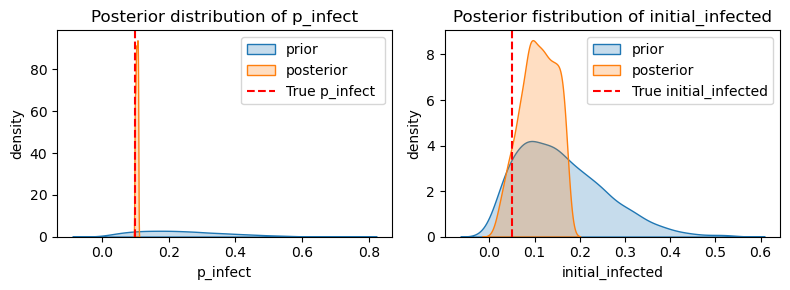

In [82]:
p_infect_prior = jax.random.beta(jax.random.PRNGKey(0), 2, 6, (1000,))
initial_infected_prior = jax.random.beta(jax.random.PRNGKey(0), 2, 10, (1000,))

samples = mcmc.get_samples()
p_infect_samps = samples['p_infect']
initial_infected_samps = samples['initial_infected']

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
sns.kdeplot(p_infect_prior, fill=True, label="prior")
sns.kdeplot(p_infect_samps, fill=True, label="posterior")
plt.axvline(x=true_p_infect, color='red', linestyle='--', label='True p_infect ')
plt.xlabel("p_infect")
plt.ylabel("density")
plt.title("Posterior distribution of p_infect")
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(initial_infected_prior, fill=True, label="prior")
sns.kdeplot(initial_infected_samps, fill=True, label="posterior")
plt.axvline(x=true_initial_infected, color='red', linestyle='--', label='True initial_infected')
plt.xlabel("initial_infected")
plt.ylabel("density")
plt.title("Posterior fistribution of initial_infected")
plt.legend()

plt.tight_layout()
plt.show()

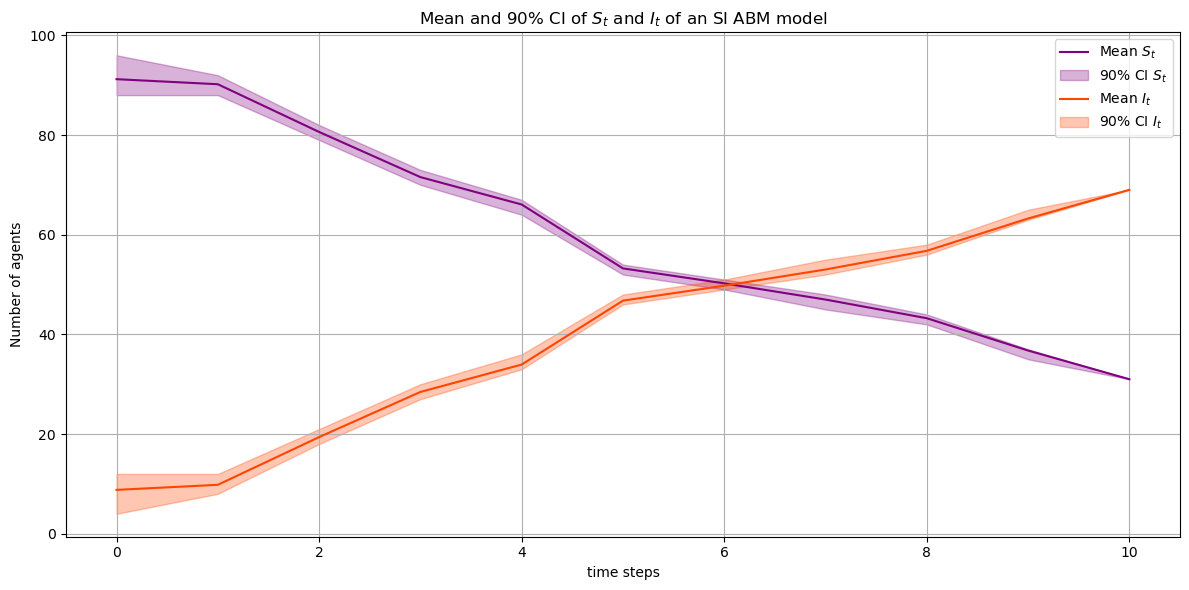

In [83]:
num_posterior_draws = len(p_infect_samps)

# store all S_t and I_t for each posterior draw
S_t_draws = []
I_t_draws = []

for i in range(num_posterior_draws):
    _, S_t, I_t = abm_SI(num_agents, num_steps, p_infect_samps[i], initial_infected_samps[i])
    S_t_draws.append(S_t)
    I_t_draws.append(I_t)

# lists to arrays
S_t_draws = jnp.array(S_t_draws)
I_t_draws = jnp.array(I_t_draws)

#  mean and credible intervals
S_t_mean = S_t_draws.mean(axis=0)
S_t_lower = jnp.percentile(S_t_draws, 5, axis=0)
S_t_upper = jnp.percentile(S_t_draws, 95, axis=0)

I_t_mean = I_t_draws.mean(axis=0)
I_t_lower = jnp.percentile(I_t_draws, 5, axis=0)
I_t_upper = jnp.percentile(I_t_draws, 95, axis=0)

# plot
time_steps = range(num_steps + 1)
plt.figure(figsize=(12, 6))
plt.plot(time_steps, S_t_mean, label="Mean $S_t$", color="purple")
plt.fill_between(time_steps, S_t_lower, S_t_upper, color="purple", alpha=0.3, label="90% CI $S_t$")   

plt.plot(time_steps, I_t_mean, label="Mean $I_t$", color="orangered")
plt.fill_between(time_steps, I_t_lower, I_t_upper, color="orangered", alpha=0.3, label="90% CI $I_t$")

plt.xlabel("time steps")
plt.ylabel("Number of agents")
plt.title("Mean and 90% CI of $S_t$ and $I_t$ of an SI ABM model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

`````{admonition}  Task
:class: tip
Repeat the procedure shown above, i.e. 1) simulation, 2) inference, 3) visualisation of trajectiories for the ABM SIR model.
`````

## Spatial SI-ABM on a lattice

To extend the model to a spatial one, on a lattice, we represent agents as nodes on a 2D grid (lattice). Each agent interacts only with its neighbors, and the infection spreads spatially based on proximity.

In [127]:
def abm_spatial_SI(grid_size, num_steps, p_infect, initial_infected):

    # initialize states on the square grid
    num_agents = grid_size ** 2
    states = jnp.zeros((grid_size, grid_size))  
    initial_infections = jax.random.bernoulli(jax.random.PRNGKey(0), initial_infected, (grid_size, grid_size))
    states = states + initial_infections  # initial infections

    # tracking S and I over time
    S_list = []
    I_list = []

    # neighborhood offsets for Moore neighborhood (8 neighbors)
    #neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    neighbors = [(-1, -1),  (-1, 1),  (1, -1),  (1, 1)]

    for step in range(num_steps):
        S_list.append(jnp.sum(1 - states))  # count susceptibles 
        I_list.append(jnp.sum(states))      # count infected agents

        # infection spreading
        new_states = states.copy()
        for i in range(grid_size):
            for j in range(grid_size):
                if states[i, j] == 1:  # already infected
                    continue
                # check neighbors for infection
                for dx, dy in neighbors:
                    ni, nj = i + dx, j + dy
                    if 0 <= ni < grid_size and 0 <= nj < grid_size:  # valid neighbor
                        if states[ni, nj] == 1:  # neighbor is infected
                            if jax.random.uniform(jax.random.PRNGKey(step + i + j)) < p_infect:
                                new_states = new_states.at[i, j].set(1)
                                break  # agent gets infected, no need to check more neighbors
        states = new_states

    S_list.append(jnp.sum(1 - states))  
    I_list.append(jnp.sum(states))      

    return states, S_list, I_list

# parameters
grid_size = 20
num_steps = 10
true_p_infect = 0.2
true_initial_infected = 0.1

# run forward spatial ABM S-I model
final_states, S_counts, I_counts = abm_spatial_SI(grid_size, num_steps, true_p_infect, true_initial_infected)

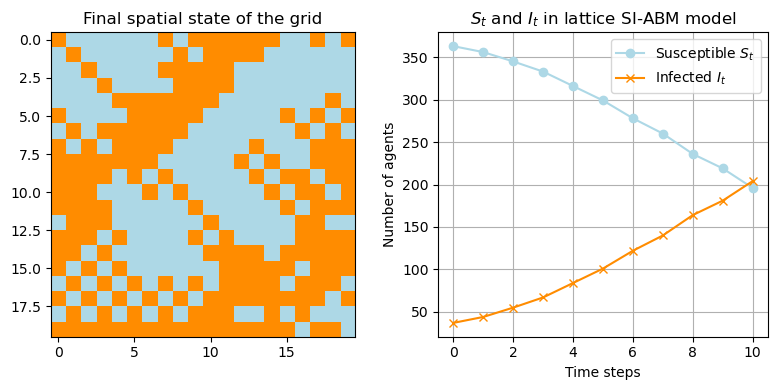

In [ ]:
colors = ["darkorange", "lightblue"]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# final spatial state
cmap = ListedColormap(colors)  
im = axes[0].imshow(final_states, cmap=cmap, interpolation="nearest")
axes[0].set_title("Final spatial state of the grid")
#axes[0].set_xlabel("x")
#axes[0].set_ylabel("y")


# S_t and I_t over time 
axes[1].plot(range(num_steps + 1), S_counts, label="Susceptible $S_t$", marker='o', color=colors[1])
axes[1].plot(range(num_steps + 1), I_counts, label="Infected $I_t$", marker='x', color=colors[0])
axes[1].set_xlabel("time steps")
axes[1].set_ylabel("number of agents")
axes[1].set_title("$S_t$ and $I_t$ in lattice SI-ABM model")
axes[1].legend()
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()